In [1]:
import numpy as np
import richdem as rd
import rioxarray as rio
from osgeo import gdal

# Notebook 07a: Comparing methods for calculating slopes

We would like to calculate mean catchment slopes based on the [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/) dataset. Initial testing using [RichDEM](https://richdem.readthedocs.io/en/latest/) highlighted some [potential problems](https://github.com/r-barnes/richdem/issues/55) when used with large grids.

This notebook explores alternatives.

In [2]:
# Choose dataset to work with (use 1 km data for develoment and testing)
data_res = 1000
in_ndv = -9999
out_ndv = 255
dst_dtype = "uint8"  # Rasterio dtypes: https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html

In [3]:
assert data_res in (1000, 100), "'data_res' must be 100 or 1000."

radr_cat_shp = (
    r"/home/jovyan/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
)
out_shp = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/radr_cats_merged_slopes.shp"

if data_res == 1000:
    dem_path = (
        r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_v3.0.tif"
    )
    rd_slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_rd_slopes.tif"
    np_slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_np_slopes.tif"
    gdal_slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_gdal_slopes.tif"
else:
    dem_path = (
        r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_v3.0.tif"
    )
    rd_slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_rd_slopes.tif"
    np_slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_np_slopes.tif"
    gdal_slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_gdal_slopes.tif"

In [4]:
def save_slope_rasterio(slope, template, slp_path, in_ndv, out_ndv, dtype):
    """Save a slope grid to disk using an existing rasterio dataset as a template.
    Makes it easier to apply compression etc. as the GDAL API is fiddly.

    Args
        slope:    Array-like. Values to save.
        template: Obj. Rioxarray dataset with the same dimensions, projection etc.
                  as the dataset you want to save. 'template' will be copied, then
                  values will be overwritten with the values in 'slope', and saved
        slp_path: Str. Path to output slope GeoTiff
        in_ndv:   Int. Value in 'slope' representing no data
        out_ndv:  Int. Value to use for no data in the output grid
        dtype:    Str. Rasterio data type (see the list here:
                    https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html

    Returns
        None. Array is saved to disk.
    """
    slope = slope.copy()
    slope[slope == in_ndv] = np.nan
    template = template.copy()
    slope = slope[np.newaxis, ...]
    template.values = slope
    template.rio.write_nodata(out_ndv, encoded=True, inplace=True)
    template.rio.to_raster(
        slp_path, compress="lzw", BIGTIFF="YES", dtype=dtype, tiled=True
    )

## 1. Explore data

In [5]:
# Read with rasterio
rds = rio.open_rasterio(dem_path, mask_and_scale=True)
print("Dataset size in memory:", rds.nbytes / 1e9, "GB.")
print("Dataset CRS:", rds.rio.crs)
print("Dataset transform:\n", rds.rio.transform())
rds

Dataset size in memory: 0.222 GB.
Dataset CRS: EPSG:3413
Dataset transform:
 | 1000.00, 0.00,-4000000.00|
| 0.00,-1000.00, 4100000.00|
| 0.00, 0.00, 1.00|


<xarray.DataArray (band: 1, y: 7500, x: 7400)>
[55500000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -4e+06 -3.998e+06 -3.998e+06 ... 3.398e+06 3.4e+06
  * y            (y) float64 4.1e+06 4.098e+06 4.098e+06 ... -3.398e+06 -3.4e+06
    spatial_ref  int64 0

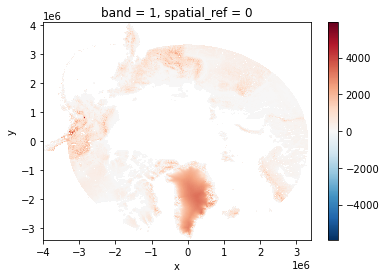

In [6]:
rds.squeeze().plot.imshow()

## 2. RichDEM

This seems like one of the nicest approaches, but initial tests showed that [RichDEM fails with large grids](https://github.com/r-barnes/richdem/issues/55). The main purpose of this notebook is to explore alternatives.

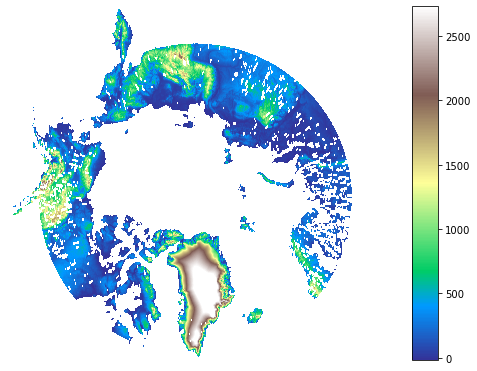

In [7]:
# Read with richdem
dem = rd.LoadGDAL(dem_path)
rd.rdShow(dem, axes=False, cmap="terrain", figsize=(8, 5.5));


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.04306                         ] (22% - 3.7s - 1 threads)


Max. slope: 57.046585 degrees.


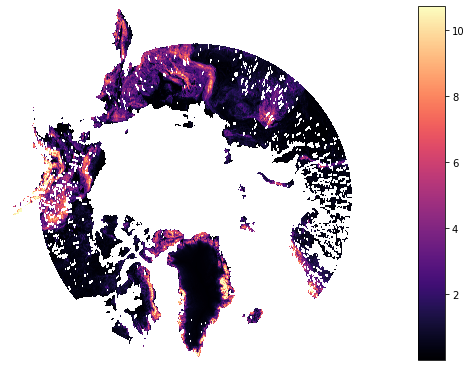

{'vmin': 0.004757633991539478, 'vmax': 10.716994514465327}

In [8]:
# Calculate slopes
rdslope = rd.TerrainAttribute(dem, attrib="slope_degrees")
save_slope_rasterio(rdslope, rds, rd_slp_path, in_ndv, out_ndv, dst_dtype)
print("Max. slope:", rdslope.max(), "degrees.")
rd.rdShow(rdslope, axes=False, cmap="magma", figsize=(8, 5.5))

## 3. Basic numpy

`np.gradient` is also a good (and robust) option, but the algorithm is slightly different. See e.g. [here](https://gis.stackexchange.com/questions/361837/calculating-slope-of-numpy-array-using-gdal-demprocessing).

Max. slope: 63.42173 degrees.


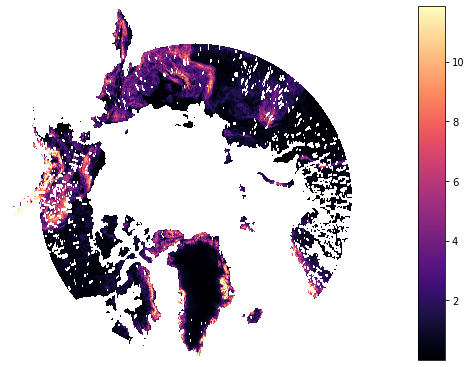

In [9]:
dem = rd.LoadGDAL(dem_path)
mask = dem == -9999
dem[mask] = np.nan
px, py = np.gradient(dem, data_res)
npslope = np.sqrt(px**2 + py**2)
npslope = np.degrees(np.arctan(npslope))
npslope[mask] = -9999
save_slope_rasterio(npslope, rds, np_slp_path, in_ndv, out_ndv, dst_dtype)
print("Max. slope:", np.nanmax(npslope), "degrees.")
rd.rdShow(npslope, axes=False, cmap="magma", figsize=(8, 5.5));

-17.42821 21.596798


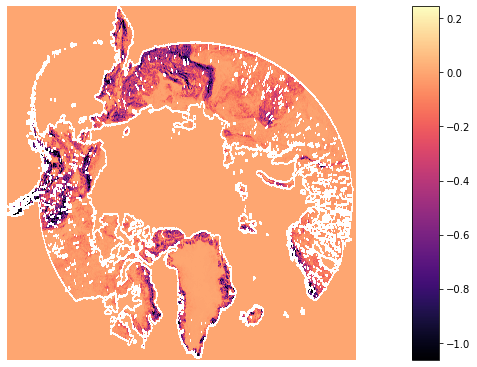

In [10]:
diffs = rdslope - npslope
print(np.nanmin(diffs), np.nanmax(diffs))
rd.rdShow(diffs, axes=False, cmap="magma", figsize=(8, 5.5));

## 4. GDAL

GDAL may be the best alternative. It seems to implement the same algorithm as RichDEM (using `alg = 'Horn'`). 

Max. slope: 57.046585 degrees.


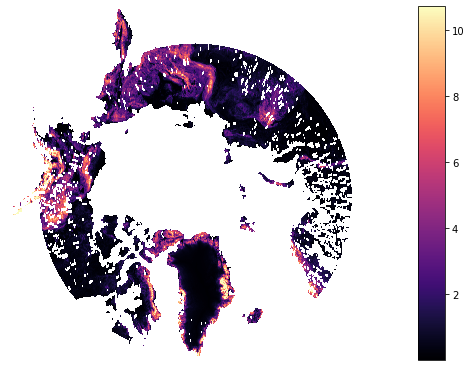

In [11]:
# Docs here: https://gdal.org/python/osgeo.gdal-module.html#DEMProcessingOptions
gdal.DEMProcessing(
    gdal_slp_path,
    dem_path,
    "slope",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    slopeFormat="degree",  # 'degree' or 'percent'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)

gdslope = rd.LoadGDAL(gdal_slp_path)
save_slope_rasterio(gdslope, rds, gdal_slp_path, in_ndv, out_ndv, dst_dtype)
print("Max. slope:", gdslope.max(), "degrees.")
rd.rdShow(gdslope, axes=False, cmap="magma", figsize=(8, 5.5));

-2.3841858e-05 10055.061


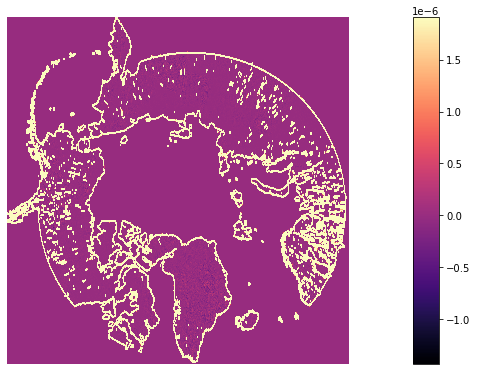

In [12]:
diffs = rdslope - gdslope
print(np.nanmin(diffs), np.nanmax(diffs))
rd.rdShow(diffs, axes=False, cmap="magma", figsize=(8, 5.5));